**https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk**

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [ ]:
import os
import sys
import re
import tqdm
import numpy as np
from numpy import mean,std
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
import itertools
from itertools import chain, product
from itertools import zip_longest

**Load Dataset**

In [ ]:
Train_data = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/Fake News Detection/Conference Paper/Data/COVID-19/Constraint_Train.csv')
Test_data = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/Fake News Detection/Conference Paper/Data/COVID-19/Constraint_Test.csv')
Val_data = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/Fake News Detection/Conference Paper/Data/COVID-19/Constraint_Val.csv')

In [ ]:
#Train_data['label'] = Train_data['label'].apply(lambda x: 1 if x == 'fake' else 0)
#Val_data['label'] = Val_data['label'].apply(lambda x: 1 if x == 'fake' else 0)

In [ ]:
Train_data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
Val_data.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [ ]:
Test_data.head()

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...


In [ ]:
Train_data.shape, Val_data.shape, Test_data.shape

((6420, 3), (2140, 3), (2140, 2))

#**Knowledge Graph**

**Import Dependencies & Load dataset**


In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# import wikipedia sentences
#candidate_sentences = pd.read_csv("../input/wiki-sentences1/wiki_sentences_v2.csv")
#candidate_sentences.shape

# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/drive/MyDrive/Natural Language Processing/Fake News Detection/Conference Paper/Data/COVID-19/Constraint_Train.csv")
candidate_sentences.shape

(6420, 3)

In [ ]:
candidate_sentences.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.,real
1,2,States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux,real
2,3,Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh...,real
4,5,Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS...,real


In [ ]:
candidate_sentences['tweet'].sample(5)

6248                                                                                    #covid19 #coronavirus #coronavirusupdate Why would Bill Gates Patent the coronavirus itself ?!? https://t.co/rJiYANQ1ls
3556                                                                                                                                                      Madagascar does not have any cases of the coronavirus
2067    #COVID19 is primarily spread through respiratory droplets. This can happen by 1. Being in close contact with an infected person 2. Touching a contaminated surface When we congregate in crowds it p...
954                                                                                                    ???My wife is suffering from coronavirus and she is pregnant. The doctor said she won???t survive it.??�
184                                                                   10 important strategies for dealing with the doomsday scenario of #COVID flu and measles. https://

**Sentence Segmentation**

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


**Entities Extraction**

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["tweet"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 6420/6420 [01:43<00:00, 62.13it/s]


In [ ]:
entity_pairs[10:20]

[['', 'how  coronavirus'],
 ['when U.S. testing', '58 coronavirus time'],
 ['first  participants', 'more https://t.co/woPlKz1bZC mRNA'],
 ['22149351  Tests', '16000'],
 ['public  Practice', 'touching practice hand more'],
 ['', 'COVID19India # COVID19India COVIDUpdates'],
 ['yet 20 he', 'back'],
 ['other lakh country', 'daily  testing'],
 ['just  we', '1 U.S. https://t.co/jNarQEkGhr https://t.co/o7EoaYeQH1'],
 ['posts', 'Australian breakfast television claim']]

**Relations Extraction**

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['tweet'])]

100%|██████████| 6420/6420 [01:27<00:00, 73.23it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is                  192
�                   141
are                 104
_                    74
shows                62
see                  53
confirmed            50
says                 48
said                 42
Says                 38
coronavirus          36
donaldtrump          34
claims               33
have                 33
's                   28
been                 27
has                  26
COVID19              25
Read                 25
Learn more           22
reported             21
CoronavirusIndia     19
Via                  19
discharged           19
claimed              18
Coronavirus          18
brings               17
See                  17
Deaths               17
tested positive      17
show                 16
remains at           16
was                  15
StaySafe             15
be                   15
are in               15
cure                 15
found                14
discharged with      14
announced            14
kill                 12
shared          

**Build Knowledge Graph**

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8419 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127999 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128659 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128163 missing from current font.
  font.s

ValueError: ignored

<Figure size 864x864 with 1 Axes>

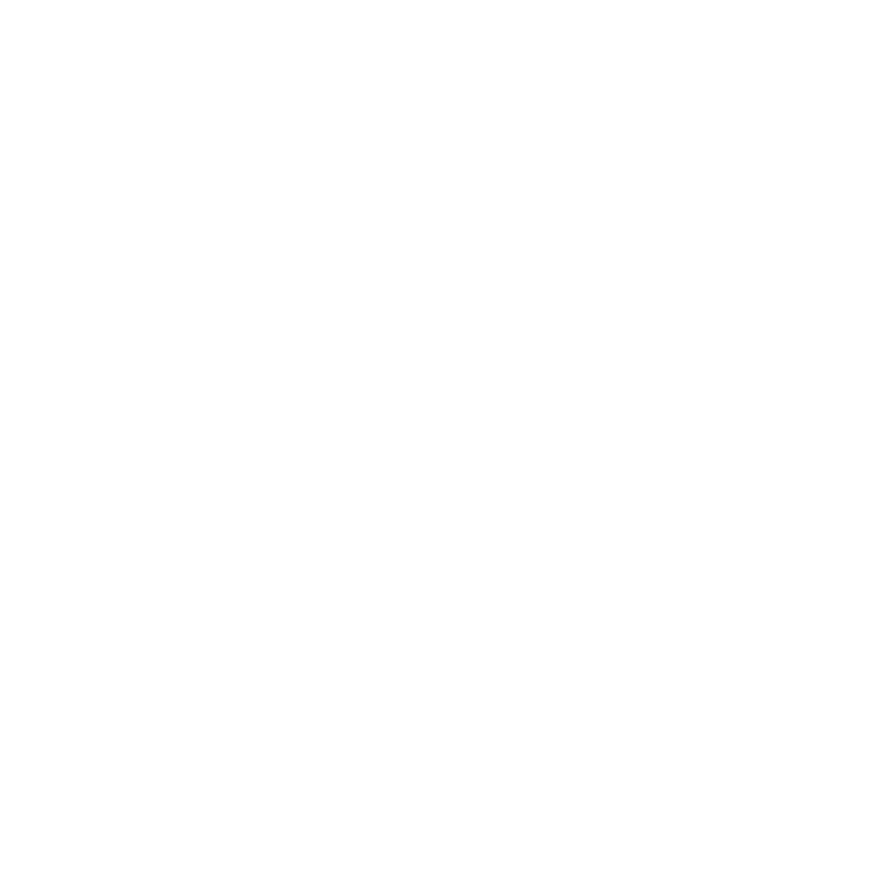

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

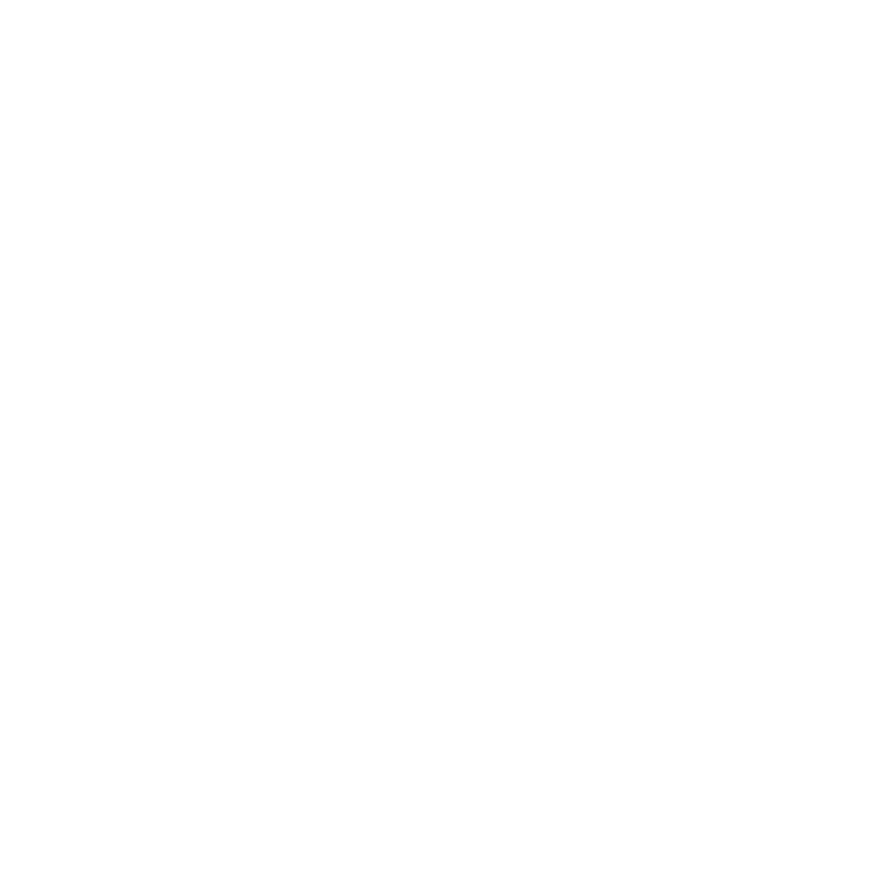

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

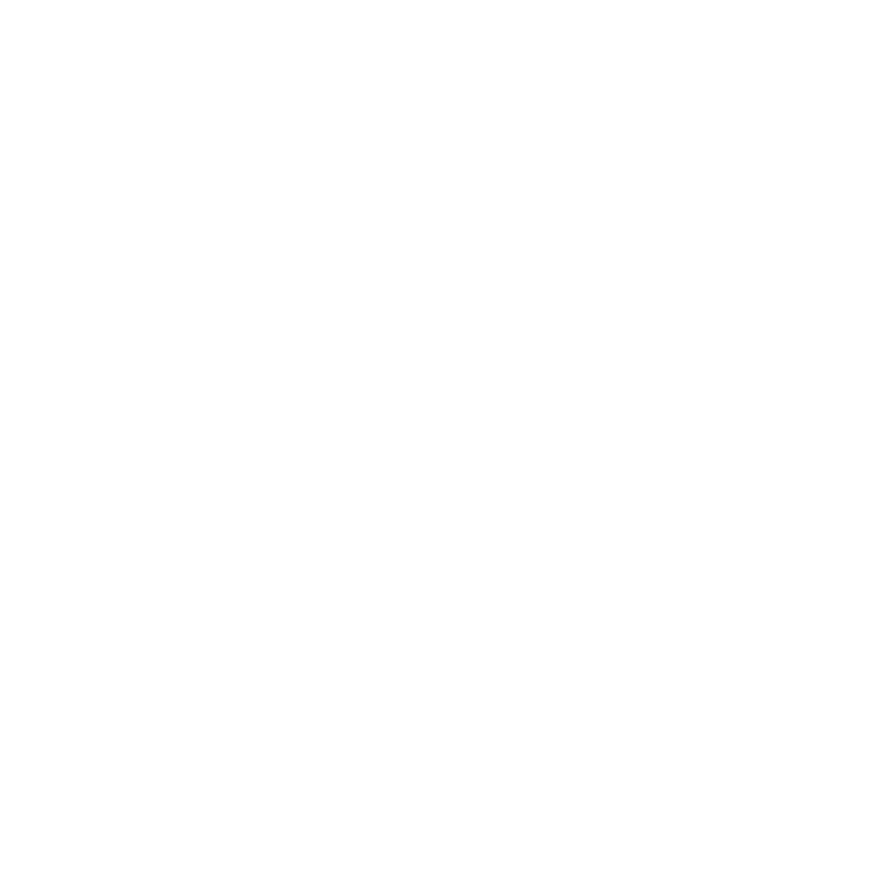

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()